<a href="https://colab.research.google.com/github/karljmurphy/logistic_regression/blob/master/CA_683_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Research question - Given that a flight has been delayed for an airline, can we predict was the flight delay due to the fault of the airline?

#Introduction

The Federal Aviation Administration (FAA) estimates that flight delays cost airlines in the region of USD22 billion annually [1]. The US Department of Transportation strictly regulates the airline industry and will administer fines of nearly USD30,000 on an airline where a plane is delayed and left sitting on the runway for over 3 hours [2]. In addition, passengers may be entitled to compensation from airlines where flights are delayed. 

The monetary consequences of flight delays do not cover the entire set of costs either. Non-monetary costs, while difficult to estimate, would need to account for stress suffered by passengers, loss of time and loss of productivity where business travellers are delayed at airports.

**(Please note, that I have not uploaded the data-set to GitHub given the size of the data-set. I have included a link [8] in the reference section at the end of the colab where the data-set can be found)**


#Literature review

Review on Machine Learning Techniques:
* Manna, et al. [4] proposed a Machine Learning Model using Gradient Boosting Decision Tree Classifier for predicting flight arrival delay using ARRIVAL_DELAY as the target variable. This analysis included instances of delays due to factors outside the control of the airline like weather.
* Gui, et al. [5] used Random Forest and LSTM architectures in an attempt to predict flight delays. In their paper, they highlight that factors like weather were used to predict flight delays
* Chakrabarty [6] used two years of flight data for one airline - American Airlines. The author used a Gradient Boosting classifier. Notably, the researcher used the ARRIVAL_DELAY information as the target variable and categorized flights under 15 minutes as "on-time" and everything else was categorized as "delayed". 
* Thiagarajan, et al. [12] adopted a Gradient Boosting classifier to conduct a classification approach and they used an Extra-Trees Regressor to predict the the delay times. The authors made extensive use of weather features in their dataset.
* Choi, et al. [9] proposed using a sampling technique called "costing" along with supervised learning on flight and weather data.
* Kim, et al. [10] utilized deep learning techniques in the form of RNNs to find patterns in day to day data of a single airport. Weather features were present in the feature set.
* Meenakshisundaram, et al. [11] used Logistic Regression and Decision Tree classifiers on a data-set that included non-flight attributes like the age of the aircraft (to capture maintence led delays) and weather data.
* Nigam, et al. [13] adopted a Logistic Regression approach to model flight data along with non-flight data "such as temperature, humidity, precipitation, dew point" to predict delays.


#Problem and motivation
As outlined in the introduction, monetary and non-monetary costs can accrue to both airlines and passengers. Therefore, the motivation is to find patterns in the data that would help us to predict where delays are likely to occur in order to minimize those costs.

The Bureau of Transportation Statistics (BTS) publishes flight delay data. The dataset that is used to conduct this research came from BTS via Kaggle [8].

A flight is considered to be "delayed" if it arrives more than 15 minutes later than the scheduled time shown in the carriers' Computerized Reservations Systems (CRS) [3]. Therefore, any flight that arrives under this 15 minute threshold is considered to be "on-time".

Airlines are mandated, by the BTS, to record explanatory information where a flight is delayed (in excess of the 15 minute threshold). There are five broad categories used by the BTS to capture information. The following information was taken from the BTS website [3]: 

**AIRLINE_DELAY:** The cause of the cancellation or delay was due to circumstances within the airline's control (e.g. maintenance or crew problems, aircraft cleaning, baggage loading, fueling, etc.).

**Extreme Weather**: Significant meteorological conditions (actual or forecasted) that, in the judgment of the carrier, delays or prevents the operation of a flight such as tornado, blizzard or hurricane.

**National Aviation System (NAS)**: Delays and cancellations attributable to the national aviation system that refer to a broad set of conditions, such as non-extreme weather conditions, airport operations, heavy traffic volume, and air traffic control.

**Late-arriving aircraft**: A previous flight with same aircraft arrived late, causing the present flight to depart late.

**Security**: Delays or cancellations caused by evacuation of a terminal or concourse, re-boarding of aircraft because of security breach, inoperative screening equipment and/or long lines in excess of 29 minutes at screening areas.

From a quick inspection of the broad categories above, we can see that AIRLINE_DELAY **(not to be confused with ARRIVAL_DELAY)** is the only category of delays that airlines have some control over. The other categories like weather, security and aviation system are beyond the control of the airlines. Late-arriving aircraft is an area that airlines potentially can control but these delays are also susceptible to weather and security impacts.

Therefore, we are interested in the following. Given a set of delayed flights, can we predict was it due to the fault of the airline or not (in other words focus on AIRLINE_DELAY only which is a sub-component of total ARRIVAL_DELAY). 

Concretely, this means that will take a subset of the dataset **where the ARRIVAL_DELAY is greater than 15 minutes**. On this subset, we will classify the observations as either late due to the airline or late but not due to the fault of the airline.

Initially, consideration was given to using the DEPARTURE_DELAY or ARRIVAL_DELAY information to classify the observations. We could simply classify flights as either "delayed" or "on-time" by looking at ARRIVAL_DELAY values only. There are two reasons why this approach was avoided. 


1.   As noted above, the airline is only able to control certain factors like baggage handling. In this paper we are interested in exploring patterns around those factors and not things like weather.
2.   Using ARRIVAL_DELAY as a target variable in isolation might be problematic. Some commentators [7] have noted how airlines can "pad" schedules so that flights that depart later than schedule can arrive on time. This would suggest that using DEPARTURE_DELAY as a target variable may have more "integrity" than using ARRIVAL_DELAY. However, both variables are still polluted to a large extent by factors like security, weather and airport operations that are out of the control of the airline and which may be highly impacted by seasonality.









#Structure of paper

This research is broken into a number of key sections that will closely follow a CRISP-DM analysis. 

In Section A, we will conduct a few preprocessing steps to minimize the size of the data-set. Concretely, we pair the observations back to hone in on one airline and the most frequently visited origin and destination airports.

Section B will take a look at some descriptive statistics about the data-set.

Section C will explore the data-set for patterns.

In Section D, we will conduct data preparation. Essentially, we will remove any unnecessary features. We will encode some categorical features. We will look at the target variable and conduct some necessary rebalancing.

In Section E, we will explore a few different models and try to classify delayed flights as:

* Delayed due to the fault of the airline
* Delayed not due to the fault of the airline

In Section F, we will use some tools to evaluate the models that we chose under the preceding section.



In [0]:
import numpy as np
import pandas
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from statsmodels.api import add_constant
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
%matplotlib inline


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [0]:
from google.colab import files
uploaded = files.upload()

Saving flights.csv to flights.csv


In [0]:
df = pd.read_csv("flights.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.



In [0]:
df.shape

(5819079, 31)

#Section A - Data Preprocessing

Given that the dataset contains over 5 million observations, we will conduct a few preprocessing steps to minimize the dataset to make it easier to work with in terms of computatational efficiency by:

1. Focus on the observations of one AIRLINE only - which will be SouthWest Airlines (WN)
2. Focus on the 10 largest ORIGIN_AIRPORTS by number of observations in the dataset
3. Focus on the 10 largest DESTINATION_AIRPORTS by number of observations in the dataset

In [0]:
df = df[(df.AIRLINE == 'WN')]

In [0]:
df = df[(df.ORIGIN_AIRPORT == 'MDW') | (df.ORIGIN_AIRPORT == 'LAS') | (df.ORIGIN_AIRPORT == 'BWI') | (df.ORIGIN_AIRPORT == 'DEN') |(df.ORIGIN_AIRPORT == 'PHX') |
       (df.ORIGIN_AIRPORT == 'DAL') | (df.ORIGIN_AIRPORT == 'HOU') | (df.ORIGIN_AIRPORT == 'ATL') | (df.ORIGIN_AIRPORT == 'MCO') |(df.ORIGIN_AIRPORT == 'LAX') ] 

In [0]:
df = df[(df.DESTINATION_AIRPORT == 'MDW') | (df.DESTINATION_AIRPORT == 'LAS') | (df.DESTINATION_AIRPORT == 'BWI') | (df.DESTINATION_AIRPORT == 'DEN') |(df.DESTINATION_AIRPORT == 'PHX') |
        (df.DESTINATION_AIRPORT == 'DAL') | (df.DESTINATION_AIRPORT == 'HOU') | (df.DESTINATION_AIRPORT == 'ATL') | (df.DESTINATION_AIRPORT == 'STL') |(df.DESTINATION_AIRPORT == 'LAX') ] 

#Section B - Data Understanding


## 1.0 Describe Data

1.1 - Shape of the dataset

In [0]:
df.shape

(163749, 31)

1.2 - First few records of dataset

In [0]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
185,2015,1,1,4,WN,4822,N293WN,LAS,BWI,600,602.0,2.0,10.0,612.0,270.0,243.0,230.0,2106,1302.0,3.0,1330,1305.0,-25.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
429,2015,1,1,4,WN,828,N8303R,PHX,BWI,610,610.0,0.0,12.0,622.0,250.0,226.0,210.0,1999,1152.0,4.0,1220,1156.0,-24.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
466,2015,1,1,4,WN,2351,N7728D,HOU,ATL,615,612.0,-3.0,7.0,619.0,110.0,106.0,91.0,696,850.0,8.0,905,858.0,-7.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
467,2015,1,1,4,WN,137,N621SW,HOU,PHX,615,613.0,-2.0,9.0,622.0,175.0,173.0,160.0,1020,802.0,4.0,810,806.0,-4.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
515,2015,1,1,4,WN,799,N7736A,LAS,HOU,620,618.0,-2.0,11.0,629.0,170.0,170.0,155.0,1235,1104.0,4.0,1110,1108.0,-2.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


1.3 - List numerical columns in the dataset

In [0]:
numerical_columns = df._get_numeric_data().columns
print(numerical_columns)

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'FLIGHT_NUMBER',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'AIR_SYSTEM_DELAY',
       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
       'WEATHER_DELAY'],
      dtype='object')


1.4 - List categorical columns in the dataset

In [0]:
def get_categorical_features():
     return list(set(df.columns) - set(df._get_numeric_data().columns))
print(get_categorical_features())

['AIRLINE', 'TAIL_NUMBER', 'DESTINATION_AIRPORT', 'CANCELLATION_REASON', 'ORIGIN_AIRPORT']


1.5 Data quality and missing values

There are a huge proportion of missing values across the dataset as highlighted below. All of these missing values are due to the fact that flight delay information is only recorded for flights that are delayed for more than 15 minutes.

"A flight delay is when an airline flight takes off and/or lands later than its scheduled time. The Federal Aviation Administration (FAA) considers a flight to be delayed when it is 15 minutes later than its scheduled time." (https://en.wikipedia.org/wiki/Flight_cancellation_and_delay) 





In [0]:
df.isnull().sum().nlargest(10)


CANCELLATION_REASON    161459
AIR_SYSTEM_DELAY       129196
SECURITY_DELAY         129196
AIRLINE_DELAY          129196
LATE_AIRCRAFT_DELAY    129196
WEATHER_DELAY          129196
ELAPSED_TIME             2892
AIR_TIME                 2892
ARRIVAL_DELAY            2892
WHEELS_ON                2401
dtype: int64

1.6 Breakdown of the number of flights per day in the dataset
 -  SAT and SUN show lower counts of flights for the airline

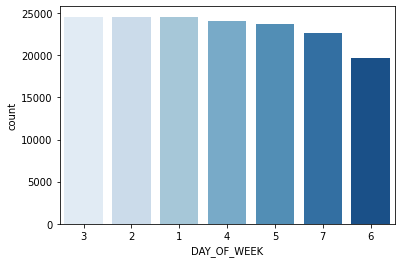

<Figure size 432x288 with 0 Axes>

In [0]:
sns.countplot(x='DAY_OF_WEEK', data=df, order = df['DAY_OF_WEEK'].value_counts().index, palette='Blues')
plt.show()
plt.savefig('count-plot')

1.7 Breakdown of numbers of flights for morning, afternoon and evening departures
Classify departures as:
0 - Morning
1 = Afternoon
2 - Evening

Observation: The number of departures is greatest in the morning for this Airline

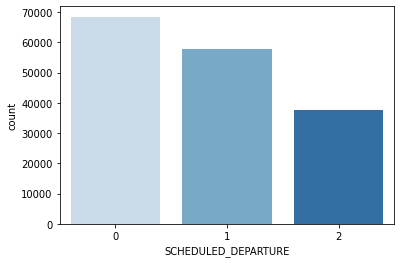

<Figure size 432x288 with 0 Axes>

In [0]:
df.loc[df["SCHEDULED_DEPARTURE"] <= 1200, 'SCHEDULED_DEPARTURE'] = 0
df.loc[(df["SCHEDULED_DEPARTURE"] > 1200) & (df["SCHEDULED_DEPARTURE"] < 1800), 'SCHEDULED_DEPARTURE'] = 1
df.loc[df["SCHEDULED_DEPARTURE"] >= 1800, 'SCHEDULED_DEPARTURE'] = 2

sns.countplot(x='SCHEDULED_DEPARTURE', data=df, order = df['SCHEDULED_DEPARTURE'].value_counts().index, palette='Blues')
plt.show()
plt.savefig('count-plot')



1.8 Breakdown for numbers of flights by distance of the flight: 
We will classify that data as follows - 

0.   Short
1.   Medium
2.   Long haul

Observation: the carrier predominantly does short haul and medium haul flights



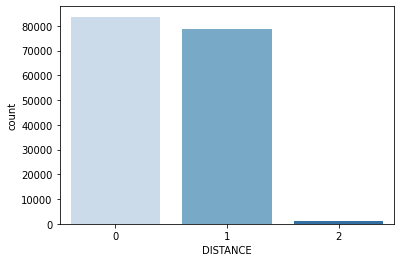

<Figure size 432x288 with 0 Axes>

In [0]:
df.loc[df["DISTANCE"] <= 800, 'DISTANCE'] = 0
df.loc[(df["DISTANCE"] > 800) & (df["DISTANCE"] < 2200), 'DISTANCE'] = 1
df.loc[df["DISTANCE"] >= 2200, 'DISTANCE'] = 2
sns.countplot(x='DISTANCE', data=df, order = df['DISTANCE'].value_counts().index, palette='Blues')
plt.show()
plt.savefig('count-plot')

1.9 Cancelled and diverted flights contain no ARRIVAL or DEPARTURE delay information

As these observations contain no arrival delay information, we will remove them from the dataset



In [0]:
df = df.drop(df[df.CANCELLED == 1].index)
df = df.drop(df[df.DIVERTED == 1].index)
df.shape

(160857, 31)

1.10 Drop all rows that have an ARRIVAL_DELAY value of less than 15 minutes. The remaining observations will be for delayed flights (reminder we are only interested in predicting if a delayed flight was due to the fault of the airline or not).

Recall from point 1.5 above that the FAA only requires airlines to document reasons for delays that are 15 minutes or above. The reasons fall under the following headings:

*   AIR_SYSTEM_DELAY
*   SECURITY_DELAY
*   AIRLINE_DELAY
*   LATE_AIRCRAFT_DELAY
*   WEATHER_DELAY


In [0]:
df = df.drop(df[df.ARRIVAL_DELAY < 15].index)
df.shape

(34553, 31)

1.11 Use AIRLINE_DELAY (note this is not the same variable as ARRIVAL_DELAY) variable as the dependent variable


*   Classify any flights that are late due to the airline's fault with a value of 1. All other flights will be coded with a zero.


In [0]:
# Examine distribution of dependent variable
df['OUTPUT'] = (df.AIRLINE_DELAY > 0).astype('int')
df.OUTPUT.value_counts()

1    22959
0    11594
Name: OUTPUT, dtype: int64

1.11 Inspect how balanced the target class variable is

We can see that the classes are heavily imbalanced. The graph is telling us that where there is a flight delay - in the majority of cases this is due to the fault of the airline. We will correct this imbalance later when preprocessing the dataset.

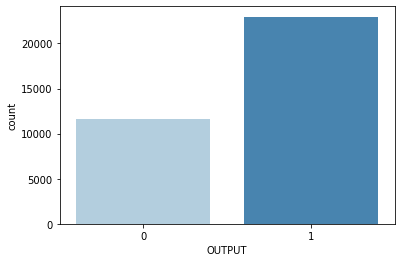

<Figure size 432x288 with 0 Axes>

In [0]:
sns.countplot(x='OUTPUT', data=df, palette='Blues')
plt.show()
plt.savefig('count-plot')

#Section C - Data exploration - analysis of patterns in the dataset

2.1 Which origin airports are the worst offenders in terms of AIRLINE_DELAY

*   At LAX, nearly 3/4 of the flights delayed are due to the AIRLINE
*   At MCO, about 1/2 of the flights delayed are due to the fault of the AIRLINE




Text(0.5, 0, 'Number of flights delayed due Airline fault (1) or something else (0)')

<Figure size 432x288 with 0 Axes>

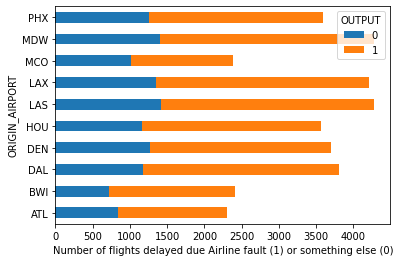

In [0]:
fig = plt.figure()
fig.suptitle('Origin Airports and types of delays', fontsize=13)
df1 = df.groupby(['ORIGIN_AIRPORT', 'OUTPUT']).size().unstack()
df1.plot(kind='barh', stacked=True).set_xlabel('Number of flights delayed due Airline fault (1) or something else (0)')

2.1 Which Destination Airports are the worst offenders in terms of AIRLINE_DELAY

Text(0.5, 0, 'Number of flights delayed due Airline fault (1) or something else (0)')

<Figure size 432x288 with 0 Axes>

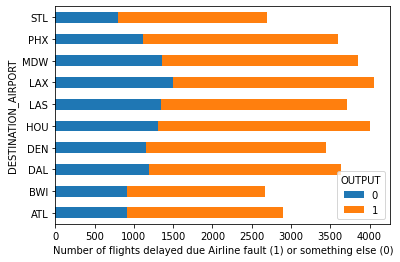

In [0]:
fig = plt.figure()
fig.suptitle('Destination airports and types of delays', fontsize=13)
df1 = df.groupby(['DESTINATION_AIRPORT', 'OUTPUT']).size().unstack()
df1.plot(kind='barh', stacked=True).set_xlabel('Number of flights delayed due Airline fault (1) or something else (0)')

2.2 Does the scheduled departure time of the flight reflect any pattern in AIRLINE_DELAY?

We can see that AIRLINE_DELAY is a bigger proportion of flights in the afternoon and the evening

Text(0.5, 0, 'Number of flights delayed due Airline fault (1) or something else (0)')

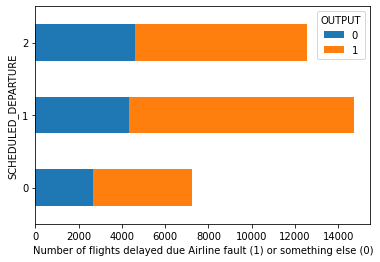

In [0]:
fig.suptitle('Scheduled departure times and type of delays', fontsize=13)
df1 = df.groupby(['SCHEDULED_DEPARTURE', 'OUTPUT']).size().unstack()
df1.plot(kind='barh', stacked=True).set_xlabel('Number of flights delayed due Airline fault (1) or something else (0)')


2.3 Do the calendar months reveal any interesting patterns in connection with AIRLINE_DELAY?

- We do see some differences with AIRLINE_DELAY being more prevalent over the summer months and the holiday months around December / January

Text(0.5, 0, 'Number of flights delayed due Airline fault (1) or something else (0)')

<Figure size 432x288 with 0 Axes>

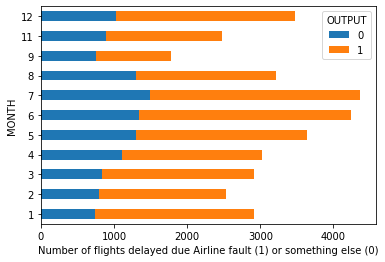

In [0]:
fig = plt.figure()
fig.suptitle('AIRLINE_DELAY by calendar months', fontsize=13)
df1 = df.groupby(['MONTH', 'OUTPUT']).size().unstack()
df1.plot(kind='barh', stacked=True).set_xlabel('Number of flights delayed due Airline fault (1) or something else (0)')

#Section D - Data Preparation


In [0]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,OUTPUT
1776,2015,1,1,4,WN,912,N433LV,BWI,STL,0,822.0,12.0,16.0,838.0,140.0,156.0,137.0,0,955.0,3.0,930,958.0,28.0,0,0,NaN,16.0,0.0,12.0,0.0,0.0,1
2806,2015,1,1,4,WN,999,N203WN,LAS,ATL,0,927.0,2.0,33.0,1000.0,225.0,238.0,199.0,1,1619.0,6.0,1610,1625.0,15.0,0,0,NaN,15.0,0.0,0.0,0.0,0.0,0
3223,2015,1,1,4,WN,3492,N732SW,LAX,PHX,0,1452.0,297.0,8.0,1500.0,75.0,70.0,57.0,0,1657.0,5.0,1210,1702.0,292.0,0,0,NaN,0.0,0.0,292.0,0.0,0.0,1
3400,2015,1,1,4,WN,2041,N8317M,LAS,DEN,0,1046.0,41.0,12.0,1058.0,115.0,107.0,88.0,0,1326.0,7.0,1300,1333.0,33.0,0,0,NaN,0.0,0.0,31.0,2.0,0.0,1
3777,2015,1,1,4,WN,972,N761RR,LAS,LAX,0,1118.0,48.0,12.0,1130.0,65.0,60.0,40.0,0,1210.0,8.0,1135,1218.0,43.0,0,0,NaN,0.0,0.0,12.0,31.0,0.0,1


3.1 Columns that can be dropped

In [0]:
# We have captured information 
# about ARRIVAL_DELAY in a new OUTPUT column.
# We remove the following columns to avoid "TARGET DATA LEAKAGE"
df = df.drop("AIRLINE_DELAY",1)
df = df.drop("DEPARTURE_DELAY",1)
df = df.drop("ARRIVAL_DELAY",1)

# We are not interested 
# in the these reasons for delay
df = df.drop("SECURITY_DELAY",1)
df = df.drop("AIR_SYSTEM_DELAY",1)
df = df.drop("LATE_AIRCRAFT_DELAY",1)
df = df.drop("WEATHER_DELAY",1)

# The following columns add
# no new information for our analysis
#df = df.drop("DAY",1)
df = df.drop("YEAR",1)
df = df.drop("CANCELLATION_REASON",1)

#df = df.drop("FLIGHT_NUMBER",1)
df = df.drop("TAIL_NUMBER",1)

df = df.drop("AIR_TIME",1)
df = df.drop("ELAPSED_TIME",1)

df = df.drop("ARRIVAL_TIME",1)
df = df.drop("SCHEDULED_TIME",1)

df = df.drop("WHEELS_OFF",1)
df = df.drop("WHEELS_ON",1)
df = df.drop("TAXI_OUT",1)
df = df.drop("TAXI_IN",1)

df = df.drop("DIVERTED",1)
df = df.drop("CANCELLED",1)

# Recall that we are only looking at one
# airline - WN - so we will delete this column
df = df.drop("AIRLINE",1)


In [0]:
df.head()

,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DISTANCE,SCHEDULED_ARRIVAL,OUTPUT
1776,1,1,4,912,BWI,STL,0,822.0,0,930,1
2806,1,1,4,999,LAS,ATL,0,927.0,1,1610,0
3223,1,1,4,3492,LAX,PHX,0,1452.0,0,1210,1
3400,1,1,4,2041,LAS,DEN,0,1046.0,0,1300,1
3777,1,1,4,972,LAS,LAX,0,1118.0,0,1135,1


3.2 Examine the correlation of the remaining numerical features

Observations:


*   SCHEDULED_DEPARTURE and SCHEDULED_ARRIVAL are highly correlated
*   DEPARTURE_TIME and SCHEDULED_DEPARTURE are highly correlated




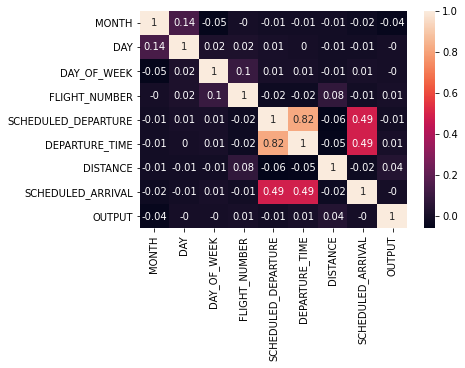

In [0]:

def run_correlation_analysis():
    numerical_columns = df._get_numeric_data().columns
    numerical_features_df = pd.DataFrame(df, columns = numerical_columns)
    correlation_matrix = numerical_features_df.corr().round(2)
    sns.heatmap(data=correlation_matrix, annot=True)
run_correlation_analysis()

3.3 Examine multicollinearity via Variance Inflation Factor

In [0]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import add_constant
import pandas as pd

numerical_columns = df._get_numeric_data().columns
numerical_features_df = pd.DataFrame(df, columns = numerical_columns)
X = add_constant(numerical_features_df)

pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)


const                  36.756865
MONTH                   1.026737
DAY                     1.022702
DAY_OF_WEEK             1.013790
FLIGHT_NUMBER           1.017424
SCHEDULED_DEPARTURE     3.203710
DEPARTURE_TIME          3.219949
DISTANCE                1.012522
SCHEDULED_ARRIVAL       1.361803
OUTPUT                  1.005397
dtype: float64

3.4 Remove following numerical variables that were found in cell 3.2 that are highly correlated with other variables in the dataset

*   DEPARTURE_TIME
*   SCHEDULED_ARRIVAL



In [0]:

df = df.drop("DEPARTURE_TIME",1)
df = df.drop("SCHEDULED_ARRIVAL",1)

In [0]:
df.head()

,MONTH,DAY_OF_WEEK,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DISTANCE,OUTPUT
1776,1,4,BWI,STL,0,0,1
2806,1,4,LAS,ATL,0,1,0
3223,1,4,LAX,PHX,0,0,1
3400,1,4,LAS,DEN,0,0,1
3777,1,4,LAS,LAX,0,0,1


3.5 Correlation analysis sanity check

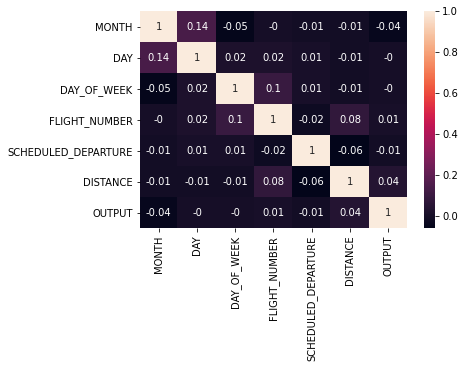

In [0]:
run_correlation_analysis()

3.6 Prepare DISTANCE and SCHEDULED_DEPARTURE variables for ONE HOT ENCODING

In [0]:
df.loc[df["DISTANCE"] == 0, 'DISTANCE'] = "SHORT"
df.loc[df["DISTANCE"] == 1, 'DISTANCE'] = "MEDIUM"
df.loc[df["DISTANCE"] == 2, 'DISTANCE'] = "LONG"

In [0]:
df.loc[df["SCHEDULED_DEPARTURE"] == 0, 'SCHEDULED_DEPARTURE'] = "MORNING"
df.loc[df["SCHEDULED_DEPARTURE"] == 1, 'SCHEDULED_DEPARTURE'] = "AFTERNOON"
df.loc[df["SCHEDULED_DEPARTURE"] == 2, 'SCHEDULED_DEPARTURE'] = "EVENING"

3.7 ONE HOT ENCODE categorical variables

In [0]:

categorical_columns = get_categorical_features()
print(categorical_columns)

['DESTINATION_AIRPORT', 'DISTANCE', 'ORIGIN_AIRPORT', 'SCHEDULED_DEPARTURE']


In [0]:
def one_hot_encode_cols(df, cols):
    df_categorical = pd.get_dummies(cols)
    df = pd.concat([df, df_categorical], axis = 1)
    return df
df = one_hot_encode_cols(df, df[categorical_columns])

In [0]:
df.head()

,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DISTANCE,OUTPUT,DESTINATION_AIRPORT_ATL,DESTINATION_AIRPORT_BWI,DESTINATION_AIRPORT_DAL,DESTINATION_AIRPORT_DEN,DESTINATION_AIRPORT_HOU,DESTINATION_AIRPORT_LAS,DESTINATION_AIRPORT_LAX,DESTINATION_AIRPORT_MDW,DESTINATION_AIRPORT_PHX,DESTINATION_AIRPORT_STL,DISTANCE_LONG,DISTANCE_MEDIUM,DISTANCE_SHORT,ORIGIN_AIRPORT_ATL,ORIGIN_AIRPORT_BWI,ORIGIN_AIRPORT_DAL,ORIGIN_AIRPORT_DEN,ORIGIN_AIRPORT_HOU,ORIGIN_AIRPORT_LAS,ORIGIN_AIRPORT_LAX,ORIGIN_AIRPORT_MCO,ORIGIN_AIRPORT_MDW,ORIGIN_AIRPORT_PHX,SCHEDULED_DEPARTURE_AFTERNOON,SCHEDULED_DEPARTURE_EVENING,SCHEDULED_DEPARTURE_MORNING
1776,1,1,4,912,BWI,STL,MORNING,SHORT,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
2806,1,1,4,999,LAS,ATL,MORNING,MEDIUM,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3223,1,1,4,3492,LAX,PHX,MORNING,SHORT,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
3400,1,1,4,2041,LAS,DEN,MORNING,SHORT,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
3777,1,1,4,972,LAS,LAX,MORNING,SHORT,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1


3.7b Drop the columns that were ONE HOT ENCODED

In [0]:
df = df.drop("SCHEDULED_DEPARTURE",1)
df = df.drop("DISTANCE",1)
df = df.drop("ORIGIN_AIRPORT",1)
df = df.drop("DESTINATION_AIRPORT",1)

df.head()

,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,OUTPUT,DESTINATION_AIRPORT_ATL,DESTINATION_AIRPORT_BWI,DESTINATION_AIRPORT_DAL,DESTINATION_AIRPORT_DEN,DESTINATION_AIRPORT_HOU,DESTINATION_AIRPORT_LAS,DESTINATION_AIRPORT_LAX,DESTINATION_AIRPORT_MDW,DESTINATION_AIRPORT_PHX,DESTINATION_AIRPORT_STL,DISTANCE_LONG,DISTANCE_MEDIUM,DISTANCE_SHORT,ORIGIN_AIRPORT_ATL,ORIGIN_AIRPORT_BWI,ORIGIN_AIRPORT_DAL,ORIGIN_AIRPORT_DEN,ORIGIN_AIRPORT_HOU,ORIGIN_AIRPORT_LAS,ORIGIN_AIRPORT_LAX,ORIGIN_AIRPORT_MCO,ORIGIN_AIRPORT_MDW,ORIGIN_AIRPORT_PHX,SCHEDULED_DEPARTURE_AFTERNOON,SCHEDULED_DEPARTURE_EVENING,SCHEDULED_DEPARTURE_MORNING
1776,1,1,4,912,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
2806,1,1,4,999,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3223,1,1,4,3492,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
3400,1,1,4,2041,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
3777,1,1,4,972,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1


3.8 Rebalance the OUTPUT classes

Here, we are going to downsample the majority class in-line with the minority class

In [0]:
df.OUTPUT.value_counts()

1    22959
0    11594
Name: OUTPUT, dtype: int64

In [0]:

from sklearn.utils import resample

df_majority = df[df.OUTPUT==1]
df_minority = df[df.OUTPUT==0]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,   
                                 n_samples=11594,     
                                 random_state=123)
 
df2 = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df2.OUTPUT.value_counts()

1    11594
0    11594
Name: OUTPUT, dtype: int64

3.9 Shuffle the dataset to ensure randomness

In [0]:
df2 = df2.sample(frac=1).reset_index(drop=True)

#Section E - Modelling


4.1 Split the dataset into Train, Validation and Test Components

In [0]:
#Code snippet taken from Stack Overflow [14]
train, validate, test = np.split(df2.sample(frac=1), [int(.6*len(df2)), int(.8*len(df2))])

In [0]:
y_train = train.OUTPUT
X_train = train.drop("OUTPUT",1)
X_train.shape

(13912, 30)

In [0]:
y_validate = validate.OUTPUT
X_validate = validate.drop("OUTPUT",1)
X_validate.shape

(4638, 30)

In [0]:
y_test = test.OUTPUT
X_test = test.drop("OUTPUT",1)
X_test.shape

(4638, 30)

In [0]:
from sklearn import preprocessing
import numpy as np
scaler = preprocessing.StandardScaler().fit(X_train)

scaler.transform(X_train)
scaler.transform(X_validate)
scaler.transform(X_test)

array([[-0.06466   ,  0.94224411, -0.43538729, ..., -0.84432139,
         1.30637467, -0.52232852],
       [ 0.55337497, -1.33049894, -0.94052515, ..., -0.84432139,
         1.30637467, -0.52232852],
       [ 1.48042743, -1.44413609, -0.94052515, ...,  1.18438312,
        -0.76547718, -0.52232852],
       ...,
       [ 1.78944492,  1.39679272, -1.445663  , ..., -0.84432139,
         1.30637467, -0.52232852],
       [ 0.86239246,  0.2604212 ,  0.57488842, ..., -0.84432139,
        -0.76547718,  1.91450393],
       [ 0.24435749,  0.94224411,  0.57488842, ...,  1.18438312,
        -0.76547718, -0.52232852]])

4.2 Create Logistic Regression Model

In [0]:
lr_model = LogisticRegression(max_iter=250)
lr_model.fit(X_train, y_train)
lr_predicted = lr_model.predict(X_validate)


In [0]:
roc_auc_score(y_validate, lr_predicted)


0.5468691331988764

4.2b Assess the importance of the features

We can see from the rankings below that features like "DAY_OF_WEEK" are ranked poorly. We highlight this here as it is an important step to conduct. Unfortunately, from experiments conducted on the dataset the removal of features did not improve the model predictions scores. So, we will leave all the features in place.

In [0]:
from sklearn.feature_selection import RFE

selectors = RFE(lr_model, n_features_to_select=1)
selectors = selectors.fit(X_train, y_train)
order = selectors.ranking_

In [0]:
feature_rankings = []

for item in order:
  feature_rankings.append(X_train.columns[item -1])
print(feature_rankings)

['ORIGIN_AIRPORT_MDW', 'SCHEDULED_DEPARTURE_EVENING', 'SCHEDULED_DEPARTURE_AFTERNOON', 'SCHEDULED_DEPARTURE_MORNING', 'FLIGHT_NUMBER', 'DESTINATION_AIRPORT_LAX', 'ORIGIN_AIRPORT_PHX', 'ORIGIN_AIRPORT_MCO', 'ORIGIN_AIRPORT_LAX', 'DESTINATION_AIRPORT_ATL', 'DESTINATION_AIRPORT_DAL', 'DESTINATION_AIRPORT_DEN', 'DESTINATION_AIRPORT_LAS', 'DAY_OF_WEEK', 'ORIGIN_AIRPORT_BWI', 'ORIGIN_AIRPORT_ATL', 'DESTINATION_AIRPORT_BWI', 'DESTINATION_AIRPORT_STL', 'DISTANCE_LONG', 'DESTINATION_AIRPORT_HOU', 'DESTINATION_AIRPORT_MDW', 'ORIGIN_AIRPORT_DEN', 'ORIGIN_AIRPORT_DAL', 'ORIGIN_AIRPORT_LAS', 'DAY', 'DESTINATION_AIRPORT_PHX', 'ORIGIN_AIRPORT_HOU', 'MONTH', 'DISTANCE_SHORT', 'DISTANCE_MEDIUM']


4.2c Remove lowest ranked features and re-compute Logistic Regression model

In [0]:
X_train  = X_train.drop("MONTH",1)
X_train  = X_train.drop("DISTANCE_SHORT",1)
X_train  = X_train.drop("DISTANCE_MEDIUM",1)

X_validate  = X_validate.drop("MONTH",1)
X_validate  = X_validate.drop("DISTANCE_SHORT",1)
X_validate  = X_validate.drop("DISTANCE_MEDIUM",1)

In [0]:
lr_model = LogisticRegression(max_iter=250)
lr_model.fit(X_train, y_train)
lr_predicted = lr_model.predict(X_validate)
roc_auc_score(y_validate, lr_predicted)

0.5321138352823582

4.3 Build a Random Forest Classifier

In [0]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(max_depth=10)
rf_model.fit(X_train, y_train)
rf_predicted = rf_model.predict(X_validate)

In [0]:
roc_auc_score(y_validate, rf_predicted)

0.5869984015800089

4.4 Build a Gradient Boosting Classifier

In [0]:
from sklearn.ensemble import GradientBoostingClassifier
gbc_model = GradientBoostingClassifier(max_depth=10
                                , n_estimators=100, learning_rate=.01)
gbc_model.fit(X_train, y_train)
gbc_predicted = gbc_model.predict(X_validate)

In [0]:
roc_auc_score(y_validate, gbc_predicted)

0.5785694559513948

4.5 Evaluation of models on the validation set

The Random Forest Classifier had the best ROC AUC SCORE of 0.587

#Section F - Model Evaluation

5.1 Evaluate Logistic Regression Model against the TEST_SET

In [0]:

def build_confusion_matrix(y_validate, predicted):
    cnf = confusion_matrix(y_validate, predicted)
    class_names=["On time","Delayed"] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')


In [0]:
lr_predicted_on_test = lr_model.predict(X_test)
roc_auc_score(y_test, lr_predicted_on_test)

0.5438814066998833

The Confusion Matrix illustrates shows the breakdown of the actual vs the predicted values

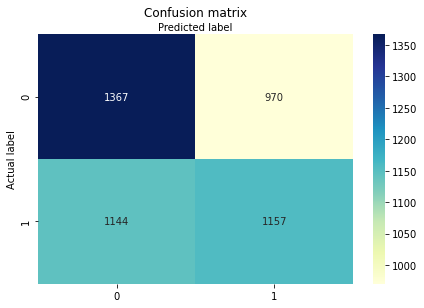

In [0]:
build_confusion_matrix(y_test, lr_predicted_on_test)

In [0]:
print(classification_report(y_test, lr_predicted_on_test,target_names=['On time', 'Delayed']))

              precision    recall  f1-score   support

     On time       0.54      0.58      0.56      2337
     Delayed       0.54      0.50      0.52      2301

    accuracy                           0.54      4638
   macro avg       0.54      0.54      0.54      4638
weighted avg       0.54      0.54      0.54      4638



5.2 Evaluate Random Forest Classifier Model against the TEST_SET

In [0]:
rf_predicted_on_test = rf_model.predict(X_test)
roc_auc_score(y_test, rf_predicted_on_test)

0.587778434224334

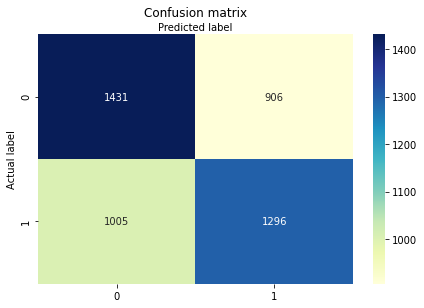

In [0]:
build_confusion_matrix(y_test, rf_predicted_on_test)

In [0]:
print(classification_report(y_test, rf_predicted_on_test,target_names=['On time', 'Delayed']))

              precision    recall  f1-score   support

     On time       0.59      0.61      0.60      2337
     Delayed       0.59      0.56      0.58      2301

    accuracy                           0.59      4638
   macro avg       0.59      0.59      0.59      4638
weighted avg       0.59      0.59      0.59      4638



5.3 Evaluate Gradient Boosting Classifier Model against the TEST_SET

In [0]:
gbc_predicted_on_test = gbc_model.predict(X_test)
roc_auc_score(y_test, gbc_predicted_on_test)

0.5717788046610309

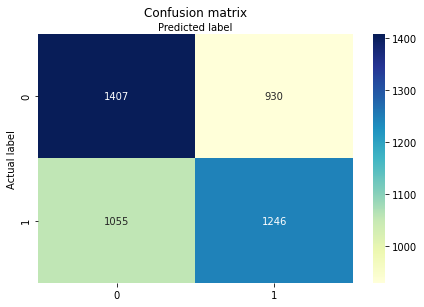

In [0]:
build_confusion_matrix(y_test, gbc_predicted_on_test)

In [0]:
print(classification_report(y_test, gbc_predicted_on_test,target_names=['On time', 'Delayed']))

              precision    recall  f1-score   support

     On time       0.57      0.60      0.59      2337
     Delayed       0.57      0.54      0.56      2301

    accuracy                           0.57      4638
   macro avg       0.57      0.57      0.57      4638
weighted avg       0.57      0.57      0.57      4638



#Conclusion

Flight delays present a huge monetary burden on airlines. As was highlighted in the literature review, there have been a number of different approaches to predicting flight delays. Most of these approaches have involved complex models with many different factors (for example weather) which is understandable. 

We have seen that a relatively simplistic model like the one that has been constructed above (that depends on flight factors alone) is not robust enough to classify flight delays. While the Random Forest classifier proved to be slightly better than Logistic Regression, the results are still weak. Any future work would involve developing a more expansive model that takes into account more non-flight factors and possibly a larger data-set covering a number of years of data.


#References

[1] Beyond Airline Disruptions. 2020. https://books.google.ie/books?id=4yOeWfX5gekC&pg=PA16&redir_esc=y#v=onepage&q&f=false

[2] Flight cancellation and delay, Wikipedia. 2020. https://en.wikipedia.org/wiki/Flight_cancellation_and_delay#cite_note-3

[3] Bureau of Transportation Statistics. 2020. https://www.bts.dot.gov/explore-topics-and-geography/topics/airline-time-performance-and-causes-flight-delays

[4] Suvojit Manna, Sanket Biswas, Riyanka Kundu, Somnath Rakshit, Priti
Gupta, Subhas Burman. 2017. "A statistical approach to predict flight delay
using gradient boosted decision tree".

[5] Guan Gui, Fan Liu, Jinlong Sun, Jie Yang, Ziqi Zhou and Dongxu Zhao. 2020. Flight Delay Prediction Based on Aviation Big Data and Machine Learning

[6] Navoneel Chakrabarty. 2019. A Data Mining Approach to Flight Arrival Delay
Prediction for American Airlines

[7] Travel Stat Exchange. 2020. https://travel.stackexchange.com/a/86547

[8] Kaggle. 2020. https://www.kaggle.com/usdot/flight-delays

[9] Sun Choi, Young Jin Kim, Simon Briceno and Dimitri Mavris. 2017. Cost-sensitive Prediction of Airline Delays Using Machine Learning

[10] Young Jin Kim, Sun Choi, Simon Briceno and Dimitri Mavris. 2016. A Deep Learning Approach to Flight Delay Prediction

[11] Swaminathan Meenakshisundaram, Shubham Sinha, Gautham Balasubramanian, Natarajan Vijayarang. 2018. A Novel Approach: Airline Delay Prediction Using Machine Learning

[12] Balasubramanian Thiagarajanα, Lakshminarasimhan Srinivasanβ, Aditya Vikram Sharmaψ, Dinesh Sreekanthanγ, Vineeth Vijayaraghavan. 2017. A Machine Learning Approach for Prediction of On-time Performance of Flights

[13] Rahul Nigam and Prof. Govinda K.. 2017. Cloud Based Flight Delay Prediction using Logistic Regression.

[14] StackOverFlow. 2020. https://stackoverflow.com/a/38251213
